# Energy Consumption Prediction
Energy Consumption Models are needed for Energy Conservation and they serve as the basic building blocks of Smart Buildings and Smart grid Systems.With the help of Deep Learning we can predict the energy consumption and deliver only that much energy which is needed and hence contriute towards energy conservation.

## Import the Dataset

In [1]:
# This will load the dataset.You will see a folder called ALL in your workspace.
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/energy.zip"
!unzip -qo energy.zip 
!rm energy.zip

--2020-12-15 17:14:53--  https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/energy.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.72
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20357475 (19M) [application/x-zip-compressed]
Saving to: ‘energy.zip’

energy.zip          100%[===================>]  19.41M  61.5MB/s    in 0.3s    

2020-12-15 17:14:53 (61.5 MB/s) - ‘energy.zip’ saved [20357475/20357475]



## Import necessary libraries

In [2]:
import numpy as np
import pandas as pd 


import os

import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

## Data Pre-processing and Data Analysis

In [3]:
 df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [4]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Dealing with Missing values

In [5]:
droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        

In [6]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [7]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

##  Mean and std of Global_active_power

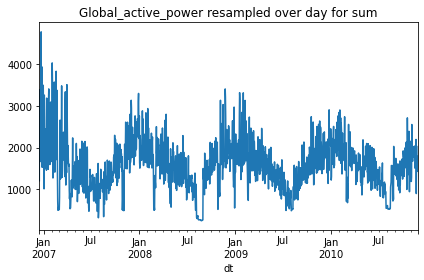

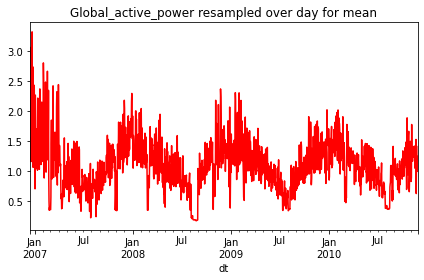

In [8]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 

plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

## Mean and std of 'Global_intensity'

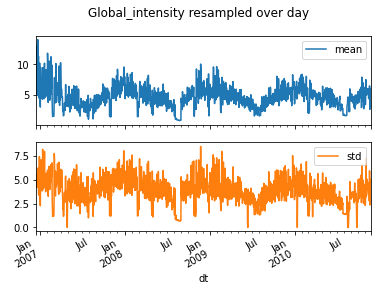

In [9]:
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

## Mean and std of Global_reactive_power

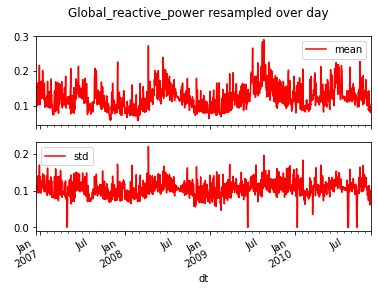

In [10]:
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

## Resample the data

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [12]:
df_resample = df.resample('h').mean() 
df_resample.shape
values = df_resample.values 


scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.545045
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.509006
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.488550
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.455597
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.322555


## Test-Train Split

In [13]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


## Model Architecture

In [14]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1))


In [15]:
model.compile(loss='mean_squared_error', optimizer='adam')


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               43200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [17]:
history = model.fit(train_X, train_y, epochs=10, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/10
126/126 - 1s - loss: 0.0197 - val_loss: 0.0116
Epoch 2/10
126/126 - 1s - loss: 0.0125 - val_loss: 0.0104
Epoch 3/10
126/126 - 1s - loss: 0.0113 - val_loss: 0.0096
Epoch 4/10
126/126 - 1s - loss: 0.0109 - val_loss: 0.0094
Epoch 5/10
126/126 - 1s - loss: 0.0107 - val_loss: 0.0092
Epoch 6/10
126/126 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 7/10
126/126 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 8/10
126/126 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 9/10
126/126 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 10/10
126/126 - 1s - loss: 0.0104 - val_loss: 0.0092


## Saving the trained Model

In [18]:
model.save("energy.h5")

## Accessing the performance of the Model

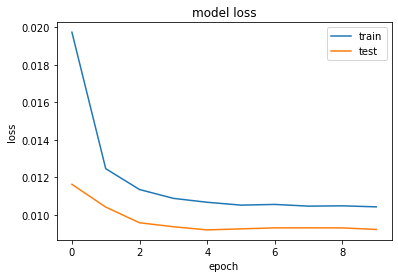

Test RMSE: 0.618


In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

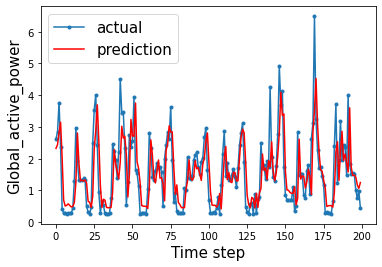

In [20]:
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

## Compiling the model with DeepC compiler

In [21]:
!deepCC energy.h5

[INFO]
Reading [keras model] 'energy.h5'
[SUCCESS]
Saved 'energy.onnx'
[INFO]
Reading [onnx model] 'energy.onnx'
[INFO]
Model info:
  ir_vesion : 4
  doc       : 
[WARNING]
[ONNX]: lstm (LSTM) has 4 inputs, that aren't connected.
[WARNING]
[ONNX]: terminal (input/output) lstm_input's shape is less than 1. Changing it to 1.
[WARNING]
[ONNX]: terminal (input/output) dense's shape is less than 1. Changing it to 1.
WARN (GRAPH): found operator node with the same name (dense) as io node.
[INFO]
Running DNNC graph sanity check ...
ERROR (GRAPH): some of graph sequential's node lstm's
               outputs are not connected to other nodes in the graph.
[ERROR]
Failed. Please check your model. graph sequential
operator Transpose {
	input lstm_input
	output lstm_X
}
operator lstm {
	input lstm_X
	input lstm_W
	input lstm_R
	input lstm_B
	output lstm_Y
	output lstm_Y_h
	output lstm_Y_c
}
operator Squeeze {
	input lstm_Y_h
	output lstm_PartitionedCall_0
}
operator dense {
	input lstm_Partitioned